In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

from dataclasses import dataclass
from collections import OrderedDict

@dataclass
class LayerRewriteResult:
    layer_idx: int
    score: float
    efficacy: float
    generalization: float
    specificity: float

In [27]:
import matplotlib.pyplot as plt
import numpy as np

#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


def visulize_sweep_results(
    layer_results: dict[int, LayerRewriteResult],
):
    layers = sorted(list(layer_results.keys()))
    data = {
        "efficacy": [layer_results[layer].efficacy for layer in layers],
        "generalization": [layer_results[layer].generalization for layer in layers],
        "specificity": [layer_results[layer].specificity for layer in layers],
        "score": [layer_results[layer].score for layer in layers],
    }
    meta_data = {
        "efficacy": {"title": "Efficacy (ES)"},
        "generalization": {"title": "Generalization (PS)"},
        "specificity": {"title": "Specificity (NS)"},
        "score": {"title": "Score (S)"},
    }

    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    for canvas, (k, v) in zip(ax, data.items()):
        canvas.plot(
            layers, v,
            linewidth=2,
        )
        canvas.set_title(k)
        canvas.set_xlabel("Edit Layer")
        # canvas.set_ylabel("Score")
        canvas.set_title(meta_data[k]["title"])
        canvas.set_ylim(0, 108)


    fig.tight_layout()
    fig.show()

In [33]:
from scripts.summarize import main as summarize
from pathlib import Path
from typing import Optional, Literal

MODEL_INFO = {
    "pythia-2.8b-deduped": {
        "n_layer": 32,
        "rewrite_module": "gpt_neox.layers.{}.mlp.dense_4h_to_h",
        "hparams": "pythia-3b.json",
        "known_data": "data/known/pythia-2.8b-deduped.json"
    },
    "mamba-2.8b": {
        "n_layer": 64,
        # "rewrite_module": "layers.{}.mixer.out_proj"
        "rewrite_module": "layers.{}.mixer.in_proj",
        "hparams": "mamba-3b.json",
        "known_data": "data/known/mamba-2.8b.json"
    }
}

#############################################################
ROME_DIR = "../../results/ROME/"
# MODEL = "pythia-2.8b-deduped"
MODEL = "mamba-2.8b"
IN_PROJ_CHANNEL: Optional[Literal["ssm", "non_ssm"]] = "non_ssm"
#############################################################

In [34]:
rewrite_module = MODEL_INFO[MODEL]["rewrite_module"].split(".")[-1]
sweep_dir = os.path.join(ROME_DIR, MODEL, rewrite_module)
if IN_PROJ_CHANNEL is not None:
    sweep_dir = os.path.join(sweep_dir, IN_PROJ_CHANNEL)
# os.listdir(sweep_dir)

In [35]:
layer_results = OrderedDict()

for layer_folder in os.listdir(sweep_dir):
    summary = summarize(
        dir_name=Path(sweep_dir) / layer_folder,
        # runs=["run_000"],
        abs_path=True
    )[0]
    layer_idx = int(layer_folder.split("_")[-1])
    layer_results[layer_idx] = LayerRewriteResult(
        layer_idx=layer_idx,
        score=summary["post_score"][0],
        efficacy=summary["post_rewrite_success"][0],
        generalization=summary["post_paraphrase_success"][0],
        specificity=summary["post_neighborhood_success"][0]
    )

{'num_cases': 2000,
 'post_neighborhood_acc': (37.64, 29.74),
 'post_neighborhood_diff': (19.1, 16.14),
 'post_neighborhood_success': (88.26, 19.63),
 'post_paraphrase_acc': (4.55, 16.02),
 'post_paraphrase_diff': (-13.66, 19.37),
 'post_paraphrase_success': (18.12, 31.47),
 'post_rewrite_acc': (31.2, 46.33),
 'post_rewrite_diff': (0.71, 43.83),
 'post_rewrite_success': (39.9, 48.97),
 'post_score': (32.758081226548356, nan),
 'run_dir': '../../results/ROME/mamba-2.8b/in_proj/non_ssm/layer_53/run_000',
 'time': (13.357433305621147, 1.980606324470255)}
{'num_cases': 2000,
 'post_neighborhood_acc': (37.46, 28.8),
 'post_neighborhood_diff': (19.24, 16.0),
 'post_neighborhood_success': (88.46, 19.6),
 'post_paraphrase_acc': (18.85, 31.89),
 'post_paraphrase_diff': (1.97, 21.98),
 'post_paraphrase_success': (45.72, 41.96),
 'post_rewrite_acc': (55.4, 49.71),
 'post_rewrite_diff': (22.37, 39.18),
 'post_rewrite_success': (69.45, 46.06),
 'post_score': (63.05745617577812, nan),
 'run_dir': '.

/tmp/ipykernel_4116605/1960460606.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


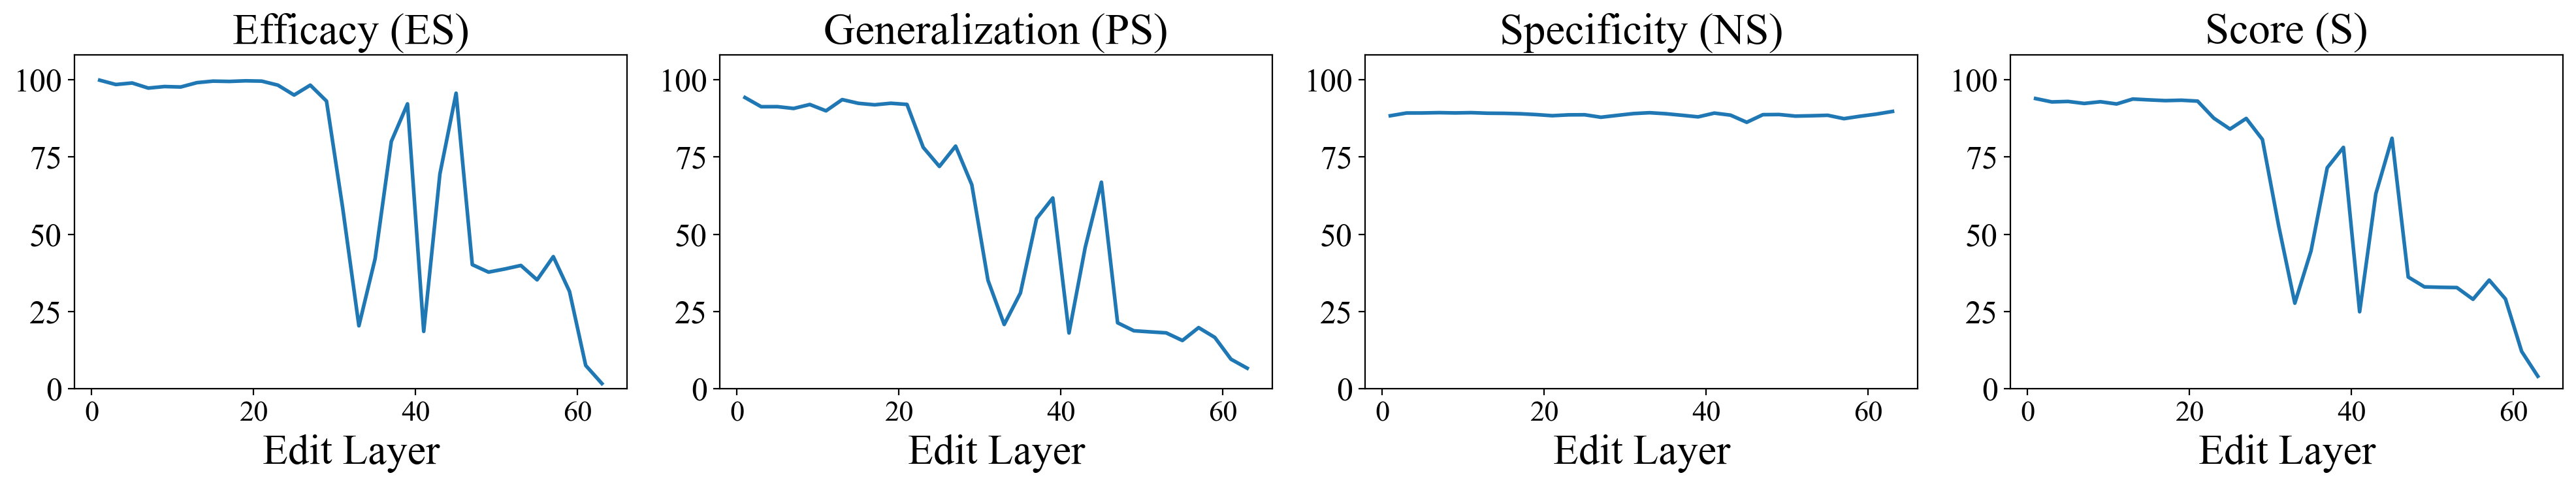

In [36]:
visulize_sweep_results(layer_results)